In [59]:
%matplotlib notebook

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import strid
import scipy.signal
import scipy.integrate
from weakref import ref

First we create a measured signal, we use a shear frame and apply a initial displacement d0 and perform FDD on the free vibration acceleration signal.

In [140]:
sf = strid.utils.ShearFrame(20, 1e3, 1e6)

# damping
freqs, damp = [5, sf.get_natural_frequency(25)], [.01]*2
sf.set_rayleigh_damping_matrix(freqs, damp)
a, b = strid.utils.find_rayleigh_damping_coeffs(freqs, damp)
xi_true = lambda w: .5*(a/w+b*w)
M, C, K = sf.M, sf.C, sf.K
fs = 100
dt = 1/fs
T = 250 #s

t = np.arange(0, T, dt)

F = np.random.normal(size=(sf.n, t.size))

A, V, D = strid.generalized_alpha_method(M, C, K, F, dt, d0, v0, rho=1)
Y = A.copy()

In [153]:
Y, V, D = sf.solve(t, F=F, d0=d0, v0=v0)
Y += np.random.normal(size=Y.shape) * 10

In [184]:
class CovSSI(object):
    def __init__(self, Y, fs):
        self.Y = Y
        self.fs = fs
        
    def R(self, i):
        """Correlation matrix between `i` first/last data matrices"""
        l, N = self.Y.shape
        return self.Y[:, :N-i].dot(self.Y[:, i:].T) /(N-i)
    
    def psd(self, **kw):
        """Compute power spectral density matrix with Welch's method
        
        Arguments
        ---------
        kw : dict
            See keywords to scipy.signal.csd and scipy.signal.welch.
            
        Returns
        -------
        f : 1darray
            Frequency vector of the psd matrix
        Pyy : 3darray
            PSD for the system, trace of the psd matrix.
        """
        psd_matrix = strid.utils.find_psd_matrix(self.Y, fs=self.fs, **kw)
        Pyy = np.trace(psd_matrix, axis1=1, axis2=2)
        f = strid.utils.get_frequency_vector(self.fs, Pyy.size)
        return f, Pyy
    
    def get_block_toeplitz(self, block_rows, lag=0):
        """Block toeplitz matrix from output correlations"""
        l, N = self.Y.shape
        T = np.zeros((l*block_rows, l*block_rows))
        for r in range(block_rows):
            for c in range(block_rows):
                i = block_rows + r - c + lag
                T[r*l:(r+1)*l, c*l:(c+1)*l] = self.R(i)
        return T
        
    def find_system_matrices(self, block_rows, max_order, min_order=5, order_step=1):
        l, N = self.Y.shape
        T = self.get_block_toeplitz(block_rows)
        U, s, VT = np.linalg.svd(T)
        system_matrices = []
        for i in range(min_order, max_order+1, order_step):
            Ui = U[:, :i]
            Si = np.diag(s[:i])
            Vi = VT[:i].T
            O = Ui.dot(np.sqrt(Si))
            Oup = O[:-l, :]
            Odwn = O[l:, :]
            Ad = np.linalg.lstsq(Oup, Odwn, rcond=None)[0]
            C = O[:l, :]
            system_matrices.append(StateSpaceSystem(Ad, C, self.fs, i))
        return system_matrices

    
class StateSpaceSystem(object):
    def __init__(self, Ad, C, fs, order):
        self.Ad = Ad
        self.C = C
        self.fs = fs
        self._order = order
        
    @property
    def order(self):
        return self.Ad.shape[0]
        
    def get_vibration_modes(self):
        lr, Q = np.linalg.eig(self.Ad)
        u = self.fs*np.log(lr)
        mask = u.imag > 0
        u = u[mask]
        Q = Q[:, mask]
        Phi = self.C.dot(Q)
        modes = [VibrationMode(ui, q) for ui, q in zip(u, Phi.T)]
        return modes
    
    
class VibrationMode(object):
    def __init__(self, eigenvalue, eigenvector):
        """Create a vibration mode object
        
        Arguments
        ---------
        eigenvalue : complex
            Eigenvalue of the mode. 
        eigenvector : ndarray[complex]
            Eigenvector or modal vector.
        """
        self.eigenvalue = eigenvalue
        self.eigenvector = eigenvector
        self._previous_modes = None
        
    @property 
    def v(self):
        return self.eigenvector / np.linalg.norm(self.eigenvector, 2)
    
    @property
    def w(self):
        u = self.eigenvalue
        return u.imag / np.sqrt(1-self.xi**2)
    
    @property
    def xi(self):
        u = self.eigenvalue
        return -u.real / np.abs(u)
    
    @property
    def f(self):
        return self.w / (2.0*np.pi)
    
    def check_stability(self, other):
        mac = strid.utils.find_modal_assurance_criterion(self.v, other.v)
        if ((np.abs(other.f-self.f) / other.f < .01)
            and (np.abs(other.xi-self.xi)/other.xi < .05)
            and (1-mac < 0.02)
           ):
            is_stable = True
        else: 
            is_stable = False
        return is_stable
    
    def is_stable(self, vibration_modes):
        is_stable = False
        for other in vibration_modes:
            if self.check_stability(other):
                is_stable = True
                if self._previous_modes is None:
                    self._previous_modes = [other]
                else:
                    self._previous_modes.append(other)
        return is_stable
    
    @property
    def mpc(self):
        u = self.v - np.mean(self.v)
        norm = np.linalg.norm
        eMPC = (norm(u.imag)**2 - norm(u.real)**2)/(2*u.real.T.dot(u.imag))
        phiMPC = np.arctan(np.abs(eMPC)+np.sign(eMPC)*np.sqrt(1+eMPC**2))
        MPC = (norm(u.real)**2+(u.real.T.dot(u.imag))*(2*(eMPC**2+1)*np.sin(phiMPC)**2-1)/eMPC) / (norm(u.real)**2 + norm(u.imag)**2)
        return MPC

In [185]:
cs = CovSSI(Y, fs)

In [186]:
systems = cs.find_system_matrices(50, 60)

<IPython.core.display.Javascript object>


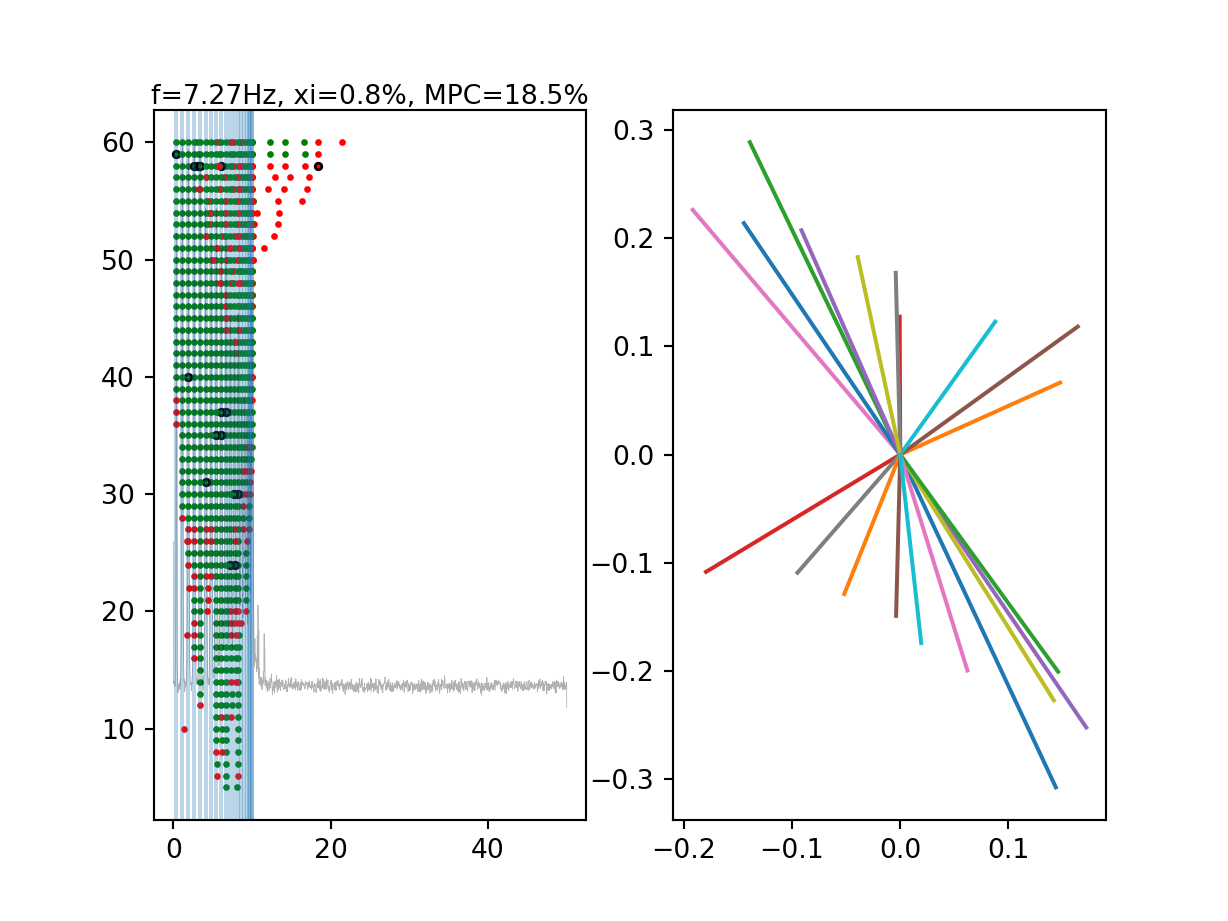

In [188]:
fig, (ax, axm) = plt.subplots(dpi=96, ncols=2)

prev_modes = systems[0].get_vibration_modes()
orders = []
f_stable = []
for system in systems:
    modes = system.get_vibration_modes()
    for mode in modes:
        
        if mode.is_stable(prev_modes):
            lines = ax.plot(mode.f, system.order, '.', color='g', ms=3, picker=2)
            lines[0].vibration_mode = mode
        else:
            lines = ax.plot(mode.f, system.order, '.', color='r', ms=3, picker=2)
            lines[0].vibration_mode = mode
    prev_modes = modes

    #ax.plot(f_stable, orders, 'o', color='g', picker=5)
#ax.plot(f_unstable, [system.order]*len(f_unstable), 'o', color='r',picker=5)
#ax.set_xlim(0, 15)
text=ax.text(0.5,1.0, "Hey", va="bottom", ha="center", transform=ax.transAxes)
cs.j = 0

picked_modes = []

def onpick(event):
    artist = event.artist
    xdata = artist.get_xdata()
    ydata = artist.get_ydata()
    
    if len(xdata) != 1:
        return True
    ms = artist.get_markersize()
    mode = artist.vibration_mode
    if ms == 3.0:
        artist.set_markersize(5)
        artist.set_mec('k')
        mpc = mode.mpc
        text.set_text(f"f={mode.f:.2f}Hz, xi={mode.xi:.1%}, MPC={mode.mpc:.1%}")
        picked_modes.append(mode)
        axm.clear()
        for ma in mode.v:
            axm.plot([0, ma.real], [0, ma.imag])
        
    else:
        artist.set_markersize(3)
        artist.set_mec(artist.get_mfc())
        picked_modes.remove(mode)
        axm.clear()
        
        
fig.canvas.mpl_connect('pick_event', onpick)
#ax2 = ax.twinx()
f, Pyy = cs.psd(nperseg=2**12)
pydb = 10*np.log10(Pyy)# / Pyy.max())
ax.plot(f, pydb/pydb.max()*60, alpha=.3, color='k', lw=.3)
#plt.sca(ax)
for i in range(1, sf.n+1):
    ax.axvline(sf.get_natural_frequency(i)/(2*np.pi), alpha=.3)

In [175]:
picked_modes = sorted(picked_modes, key=lambda x: x.f)
for i, mode in enumerate(picked_modes):
    true_freq = sf.get_natural_frequency(i+1) / (2*np.pi)
    err = (true_freq - mode.f)/(true_freq)
    v_true = sf.get_mode_shape(i+1)
    v = mode.v.real / np.abs(mode.v.real) * np.abs(mode.v)
    mac = strid.utils.find_modal_assurance_criterion(v_true, v)
    print(f"{mode.f:>5.1f} Hz | {err:>5.1%} | {mode.xi:>5.1%} | {mac:>6.1%}")

  0.4 Hz | -0.0% |  1.8% |  99.7%


<IPython.core.display.Javascript object>


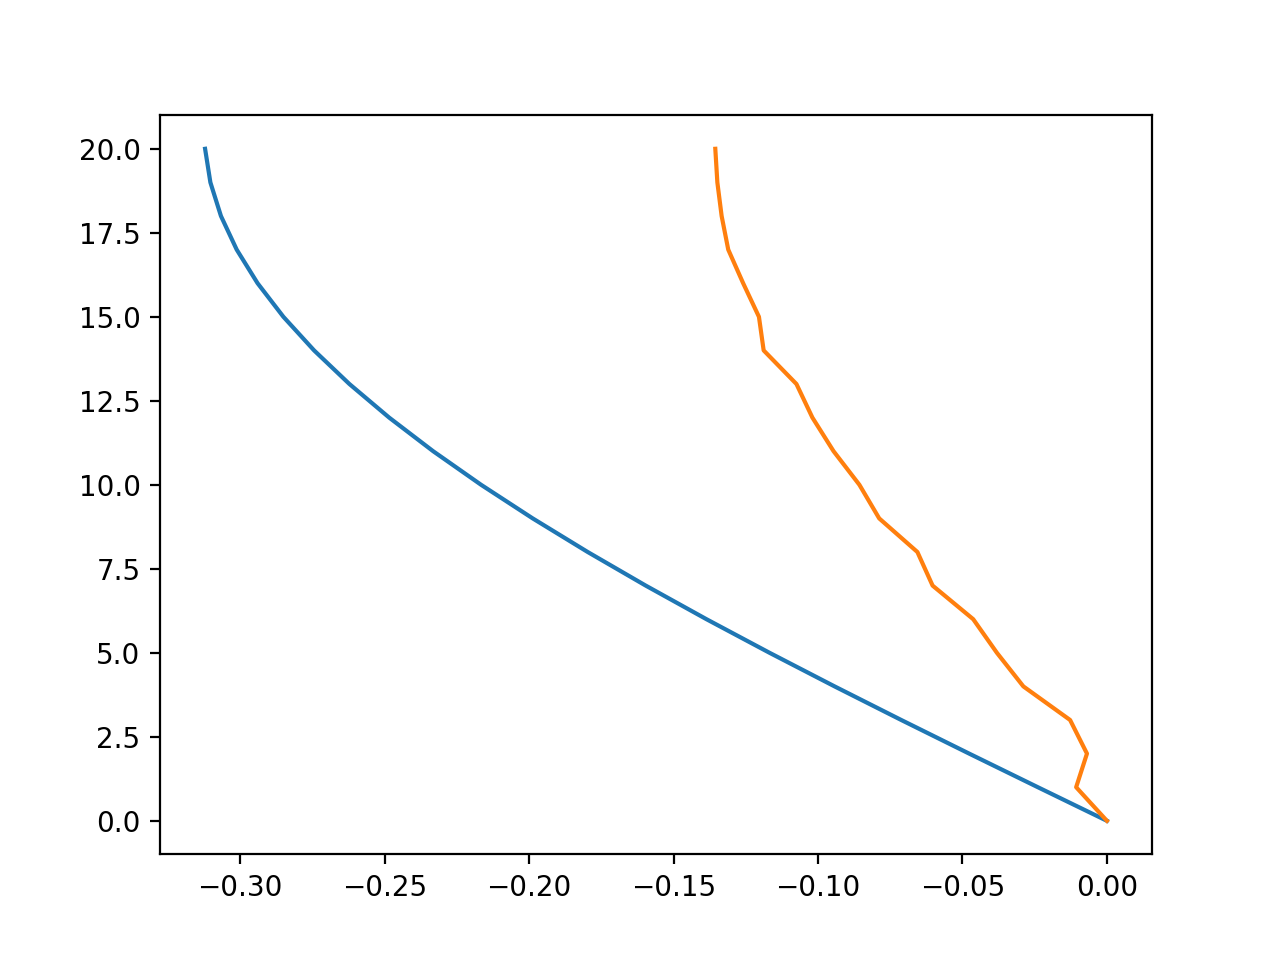

<IPython.core.display.Javascript object>


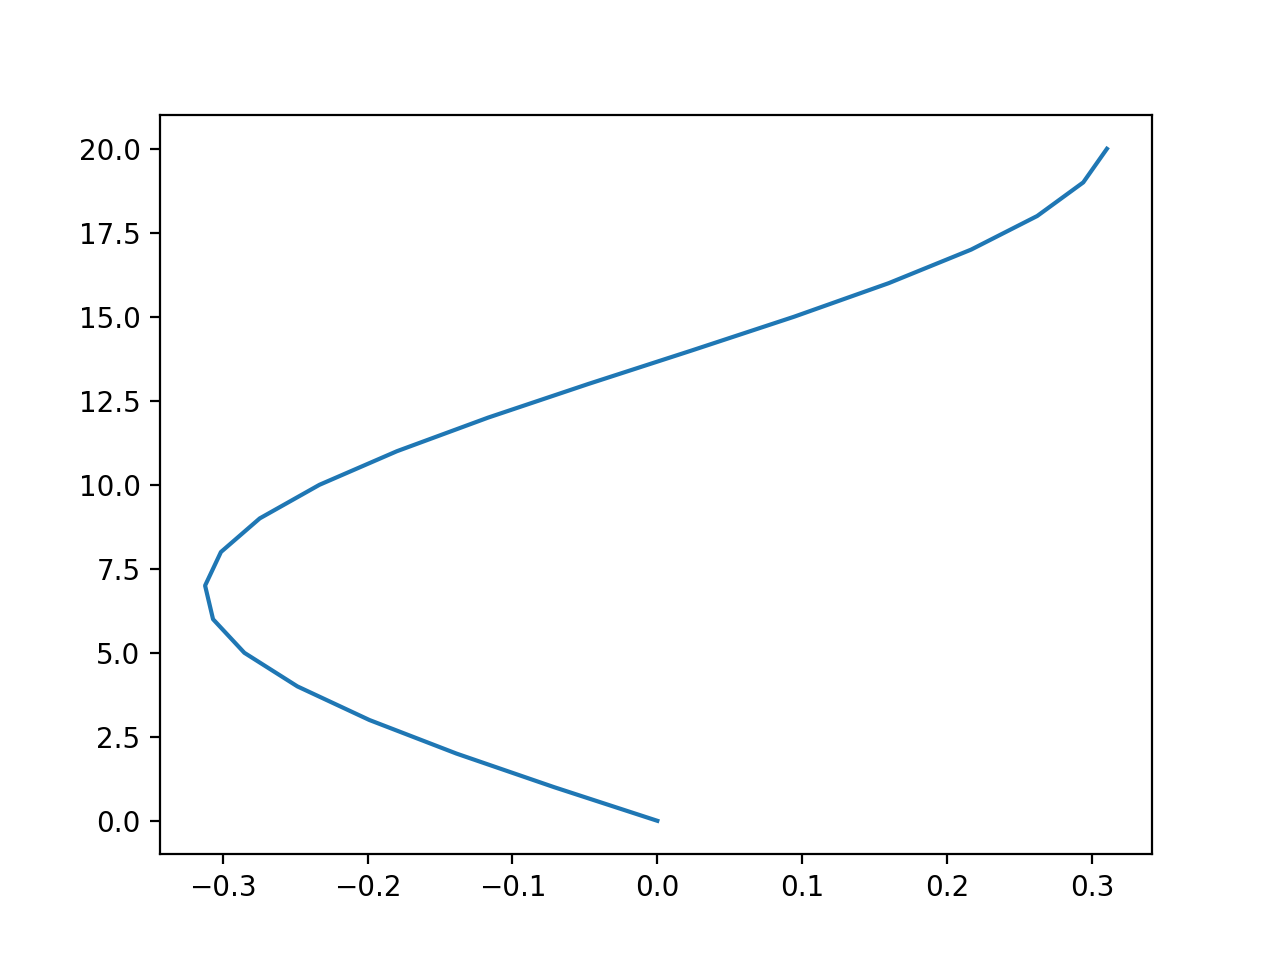

IndexError: list index out of range

In [178]:
for i in range(1, 10):
    plt.figure()
    
    v = np.r_[0, sf.get_mode_shape(i)*-1]
    plt.plot(v, np.arange(v.size))
    
    v2 = np.r_[0, picked_modes[i-1].v.real]
    plt.plot(v2, np.arange(v2.size))
    

<IPython.core.display.Javascript object>


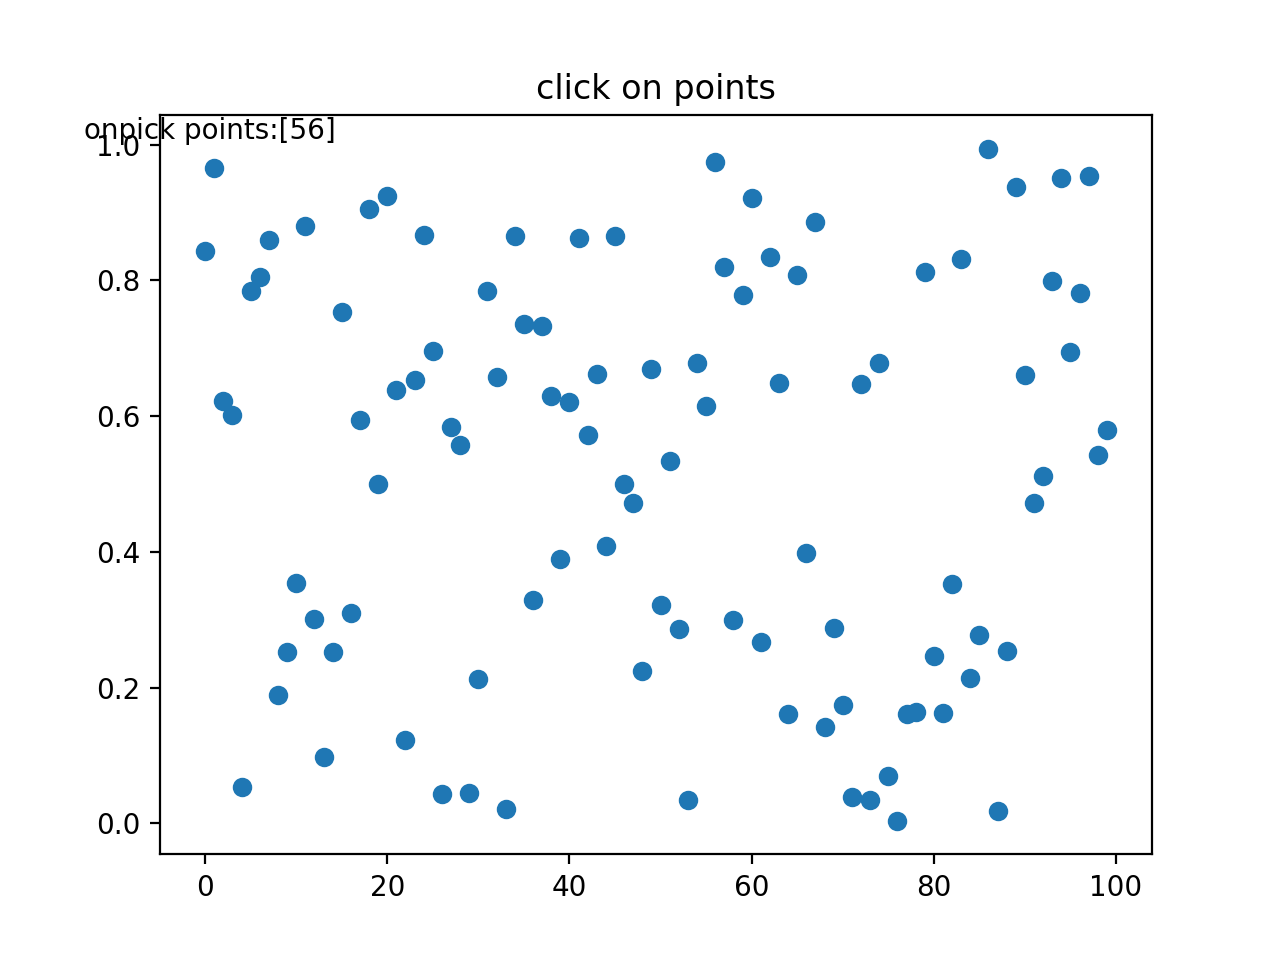

7

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click on points')

line, = ax.plot(np.arange(100), np.random.rand(100), 'o', picker=5)  # 5 points tolerance
text = ax.text(.5, 1.0, "", va='bottom', ha='center', )
def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    points = tuple(zip(xdata[ind], ydata[ind]))
    text.set_text('onpick points:' + str(ind))

fig.canvas.mpl_connect('pick_event', onpick)



In [11]:
As = cs.compute_state_matrix_BR(5, 60, 2)

(0, 20)

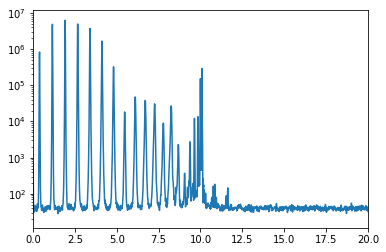

In [18]:
f, Pyy = cs.psd(nperseg=2**13)
plt.semilogy(f, Pyy)
plt.xlim(0, 20)

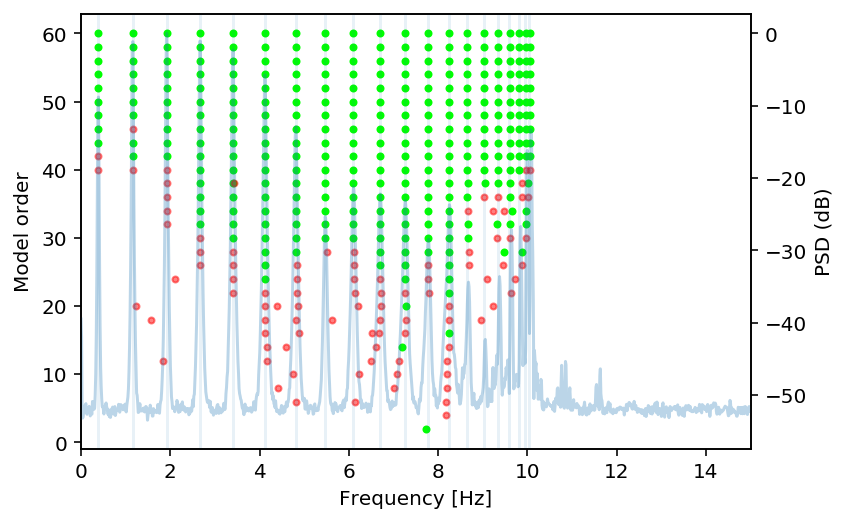

In [19]:
plt.figure(dpi=144)
w0 = None
xi0 = None
id_results = {}
for i, A, C in As:
    lr, Q = np.linalg.eig(A)
    u = cs.fs*np.log(lr)
    mask = u.imag > 0
    u = u[mask]
    Q = Q[:, mask]
    Phi = C.dot(Q)
    modes = [VibrationMode(ui, q) for ui, q in zip(u, Phi.T)]
    id_results[i] = modes
    try:
        prev_i = [*id_results.keys()][-2]
    except IndexError:
        prev_i = i
    for mode in modes:
        
        if mode.is_stable(id_results[prev_i]):
            c = (0, 1, 0, 1)
        else:
            c = (1, 0, 0, .5)
        plt.plot(mode.f, i, '.', color=c)
plt.ylabel("Model order")
plt.xlabel("Frequency [Hz]")
ax2 = plt.gca().twinx()
ax2.plot(f, 10 * np.log10(Pyy / Pyy.max()), alpha=.3)
plt.xlim(0, 15)
plt.ylabel("PSD (dB)")
for r in range(1, sf.n+1):
    plt.axvline(sf.get_natural_frequency(r)/(2*np.pi), alpha=.1)

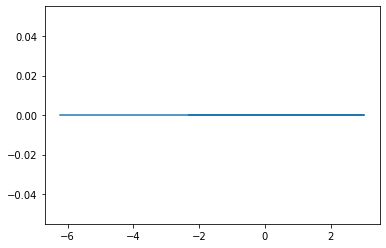

In [17]:
modes = id_results[50]

mode = modes[0]
plt.plot(mode.v.real, mode.v.imag)


In [42]:
3*10**8*8.85*10**(-12)*(21.7*10**(-3))**2

1.2502129499999999e-06

(20, 60) (60, 31)
(20, 31)


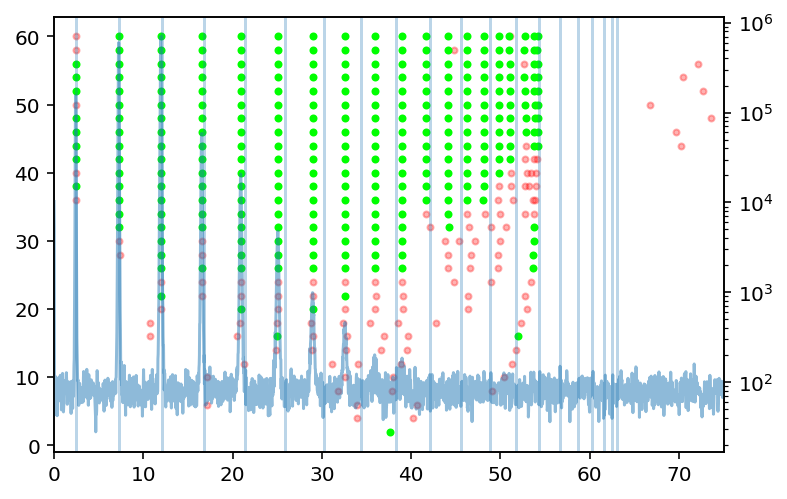

In [43]:
plt.figure(dpi=144)
w0 = None
xi0 = None
id_result = {}
for i, A, C in As:
    lr, Q = np.linalg.eig(A)
    u = cs.fs*np.log(lr)
    mask = u.imag > 0
    u = u[mask]
    Q = Q[:, mask]
    Phi = C.dot(Q)
    modes = [VibrationMode(ui, q) for ui, q in zip(u, Phi.T)]
    id_result[i] = modes
    
    
    xi = -u.real / np.abs(u)
    w = u.imag / np.sqrt(1-xi**2)
    
    if w0 is None:
        w0 = w
        xi0 = xi
    for xii, wi in zip(xi, w):
        c = (1, 0, 0, .3)
        if np.any((np.abs(w0 - wi)/w0 < 0.01) & (np.abs(xi0-xii)/(xi0)<0.05)):
            c = (0, 1, 0, 1)
        plt.plot(wi, i, '.', color=c)
    plt.xlim(0, 75)
    w0 = w
    xi0 = xi
print(C.shape, Q.shape)
print(Phi.shape)
for r in range(1, cs.Y.shape[0]+1):
    plt.axvline(sf.get_natural_frequency(r), alpha=.3)
    
ax2 = plt.gca().twinx()
psd = np.trace(Pyy, axis1=1, axis2=2)
f = strid.utils.get_frequency_vector(fs, psd.size)
ax2.semilogy(f*2*np.pi, psd, alpha=.5)

  63.1 |  63.1 |     0.1% | 77.0% | 19
  60.3 |  60.3 |     0.1% | 80.2% | 24
  56.7 |  56.7 |     0.0% | 97.8% | 14
  48.8 |  48.8 |     0.0% | 88.4% | 11
  42.1 |  42.1 |     0.0% | 99.2% | 9
  38.3 |  38.3 |     0.0% | 99.4% | 8
  25.9 |  25.9 |     0.0% | 99.9% | 5
  30.2 |  30.2 |     0.0% | 76.1% | 6
  21.4 |  21.4 |     0.0% | 100.0% | 4
  34.4 |  34.4 |     0.0% | 99.7% | 7
  16.8 |  16.8 |    -0.0% | 100.0% | 3
  12.0 |  12.0 |    -0.0% | 100.0% | 2
   7.3 |   7.3 |     0.0% | 78.8% | 1


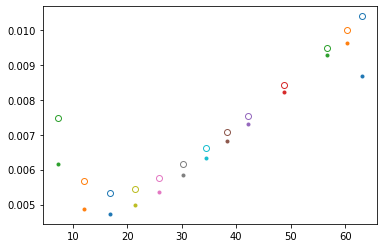

In [27]:
Qs = [(sf.get_natural_frequency(r), sf.get_mode_shape(r)) for r in range(1, 26)]
for xii, wi, phi in zip(xi, w, Phi.T):
    macs = [strid.utils.find_modal_assurance_criterion(phi, qr) for wr, qr in Qs]
    i = np.argmax(macs)
    if macs[i] < .75:
        continue
    wr, qr = Qs[i]
    err_w = (wi-wr)/wr
    mac = macs[i]
    print(f"{wi:>6.1f} | {wr:>5.1f} | {err_w:>8.1%} | {mac:>5.1%} | {i}")
    lines = plt.plot(wi, xi_true(wi), 'o', mfc="w", ms=6)
    plt.plot(wi, xii, '.', color=lines[0].get_mec())

#plt.plot(phi, label='$\\phi$')
#plt.plot(qr)
#plt.plot(sf.find_mode_shape(2))
#plt.legend()
#plt.plot(macs)

In [194]:
cs = CovSSI(Y, fs)
A = cs.compute_state_matrix_BR(10, None)
lr, Q = np.linalg.eig(A)
u = fs * np.log(lr)
w = np.sort(u.imag)
w = w[w>0]
w, xi, Q = cs.find_modal_prop(20)


plt.plot(w, xi)
print([sf.find_natural_frequency(r) for r in range(1, 11)])
print(w)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [45]:
np.log(1+1j)

(0.34657359027997264+0.7853981633974483j)

In [49]:
np.log(1+0j)

0j

In [47]:
np.log(1)

0.0